# SVMs for Activity Recognition

In this lab, you haave to use SVMs for *activity recognition*, i.e. determining the type of activity a person is doing using sensor data like accelerometers in a smartphone.

<table align='left'>
<tr>
<td><img width='550'  align='left' src='http://jricardon.github.io/BBS19lab3Files/figs/AR_pic.jpg'></td>
<td><img width='400'  align='left' src='http://jricardon.github.io/BBS19lab3Files/figs/wearable_TEG.png'></td>
</tr>
</table>







# Data & Problem Description

You will use a pre-processed dataset produced from real data originally collected by collegues from the University of Genova and the Polytechnic University of Catalonia, named "Activity Recognition Using Smart Phones Dataset". Details regarding the data collection methodology are provided in the following paper:


> Anguita, D., Ghio, A., Oneto, L., Parra, X., & Reyes-Ortiz, J. L. *A public domain dataset for human activity recognition using smartphones*. 2013.

The experiments were carried out with a group of 30 volunteers within an age bracket of 19-48 years. Each person performed six activities (WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS, SITTING, STANDING, LAYING) wearing a smartphone (Samsung Galaxy S II) on the waist. Using its embedded accelerometer and gyroscope, the reseachers captured 3-axial linear acceleration and 3-axial angular velocity at a constant rate of 50Hz. The obtained dataset was randomly partitioned into two sets, where 70% of the volunteers was selected for generating the training data and 30% the test data. 


## Activities


**1.   Explore the dataset to determine the type of data you have, the proportion of missing values, the proportion of examples in each class, the approximate distribution of each feature and the presence of outliers. Do you see variable with extremely skew distributions? Evaluate the convinience of a manual transformation.**

**Imports:**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import plot_confusion_matrix, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn import datasets, svm, metrics
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.multiclass import OneVsOneClassifier
from sklearn.multiclass import OutputCodeClassifier
from sklearn.multiclass import OneVsRestClassifier

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import random

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


**Uploading the Data to Google Colab:**

In [5]:
from google.colab import files
uploaded = files.upload()

Saving test.csv to test.csv
Saving train.csv to train.csv


In [0]:
import io
train = pd.read_csv(io.BytesIO(uploaded['train.csv']))
test = pd.read_csv(io.BytesIO(uploaded['test.csv']))

**Checking if the data uploaded correctly:**

In [7]:
print(train.head())

   tBodyAcc-mean()-X  tBodyAcc-mean()-Y  ...  subject  Activity
0           0.288585          -0.020294  ...        1  STANDING
1           0.278419          -0.016411  ...        1  STANDING
2           0.279653          -0.019467  ...        1  STANDING
3           0.279174          -0.026201  ...        1  STANDING
4           0.276629          -0.016570  ...        1  STANDING

[5 rows x 563 columns]


In [8]:
print(test.head())

   tBodyAcc-mean()-X  tBodyAcc-mean()-Y  ...  subject  Activity
0           0.257178          -0.023285  ...        2  STANDING
1           0.286027          -0.013163  ...        2  STANDING
2           0.275485          -0.026050  ...        2  STANDING
3           0.270298          -0.032614  ...        2  STANDING
4           0.274833          -0.027848  ...        2  STANDING

[5 rows x 563 columns]


**Checking the unique values of the target class:**

In [9]:
classes = test["Activity"].unique()
classes.sort()
print(classes)


['LAYING' 'SITTING' 'STANDING' 'WALKING' 'WALKING_DOWNSTAIRS'
 'WALKING_UPSTAIRS']


**Exploring the types of data:**

All the variables included are of the type float, except for the subject that is an integer, and the activity type that is an object.

In [18]:
train.dtypes

tBodyAcc-mean()-X       float64
tBodyAcc-mean()-Y       float64
tBodyAcc-mean()-Z       float64
tBodyAcc-std()-X        float64
tBodyAcc-std()-Y        float64
                         ...   
angle(X,gravityMean)    float64
angle(Y,gravityMean)    float64
angle(Z,gravityMean)    float64
subject                   int64
Activity                 object
Length: 563, dtype: object

**Looking at the activity proportions:**

From the diagrams below it can be seen that the count values of the six activities are not dramatically different, with a slightly less amount of observations for the categories of "walking downstairs" and "walking upstairs", but overall the counts range from 986 to 1407. Largely similar proportions can be observed for the test set. 

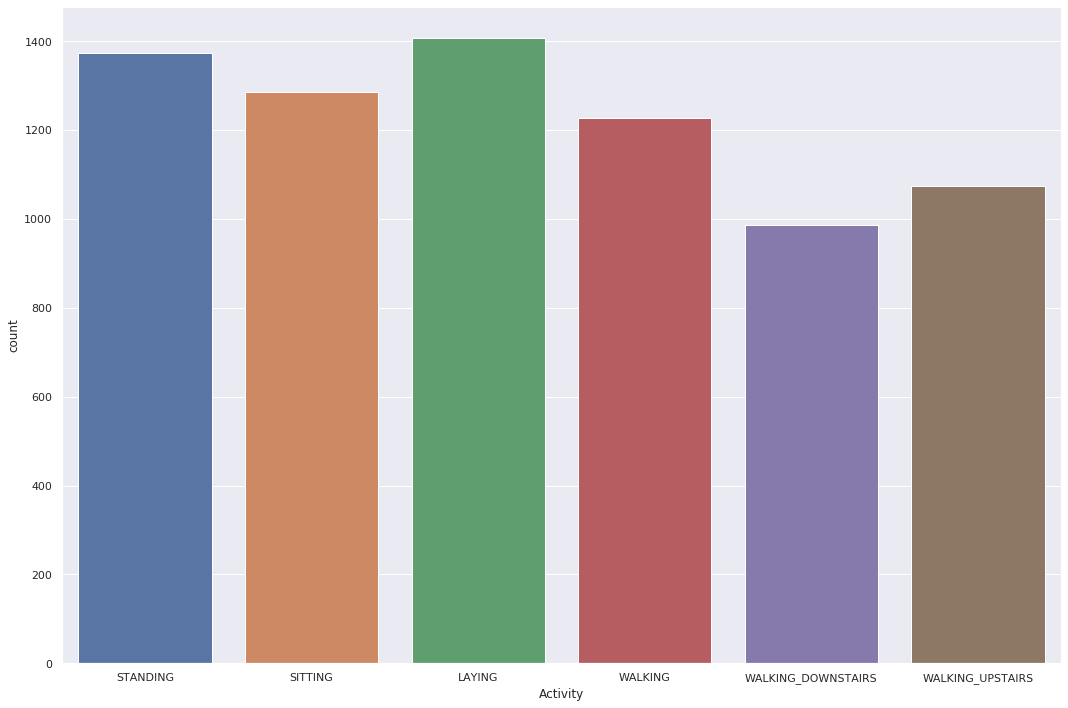

In [11]:
plt.figure(figsize = (15, 10))
sns.countplot(x = 'Activity', data = train)
plt.tight_layout()
plt.show()

In [12]:
train['Activity'].value_counts()

LAYING                1407
STANDING              1374
SITTING               1286
WALKING               1226
WALKING_UPSTAIRS      1073
WALKING_DOWNSTAIRS     986
Name: Activity, dtype: int64

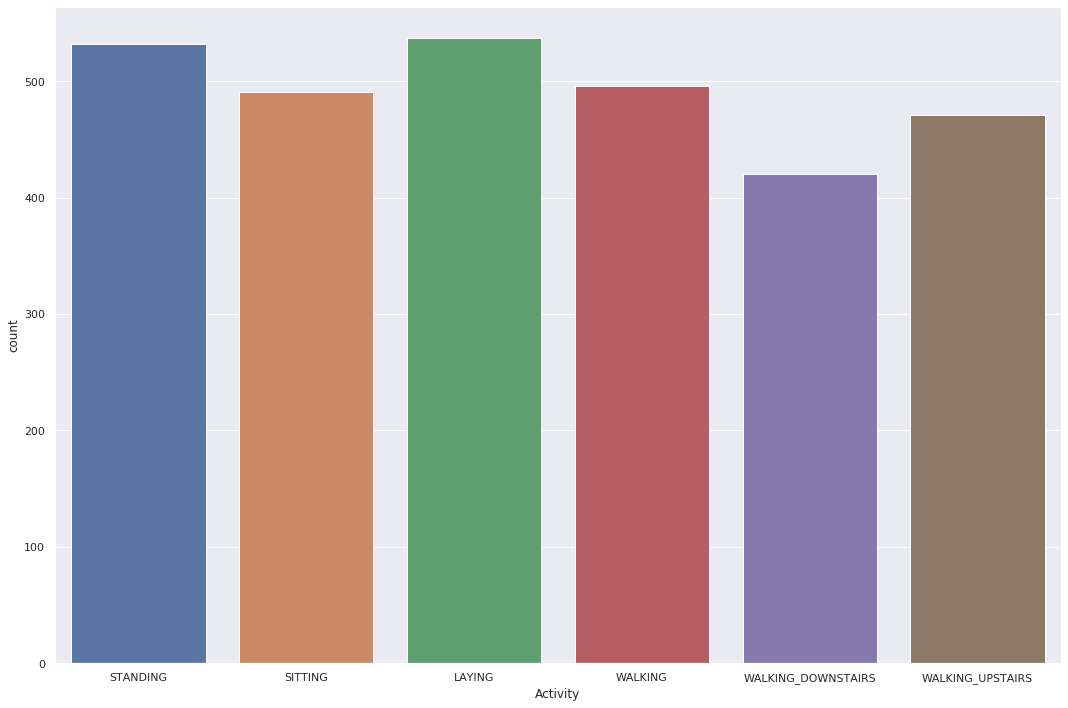

In [13]:
plt.figure(figsize = (15, 10))
sns.countplot(x = 'Activity', data = test)
plt.tight_layout()
plt.show()

In [14]:
test['Activity'].value_counts()

LAYING                537
STANDING              532
WALKING               496
SITTING               491
WALKING_UPSTAIRS      471
WALKING_DOWNSTAIRS    420
Name: Activity, dtype: int64

**Checking for missing values**:

Missing values are absent in the dataset

In [17]:
print("Missing values in the training set:",train.isnull().values.sum())
print("Missing values in the test set:",test.isnull().values.sum(), "\n")

Missing values in the training set: 0
Missing values in the test set: 0 



**Visual evaluation of some of the variables:**

 The visualizations shows that the distributions are skewed and with very many outliers

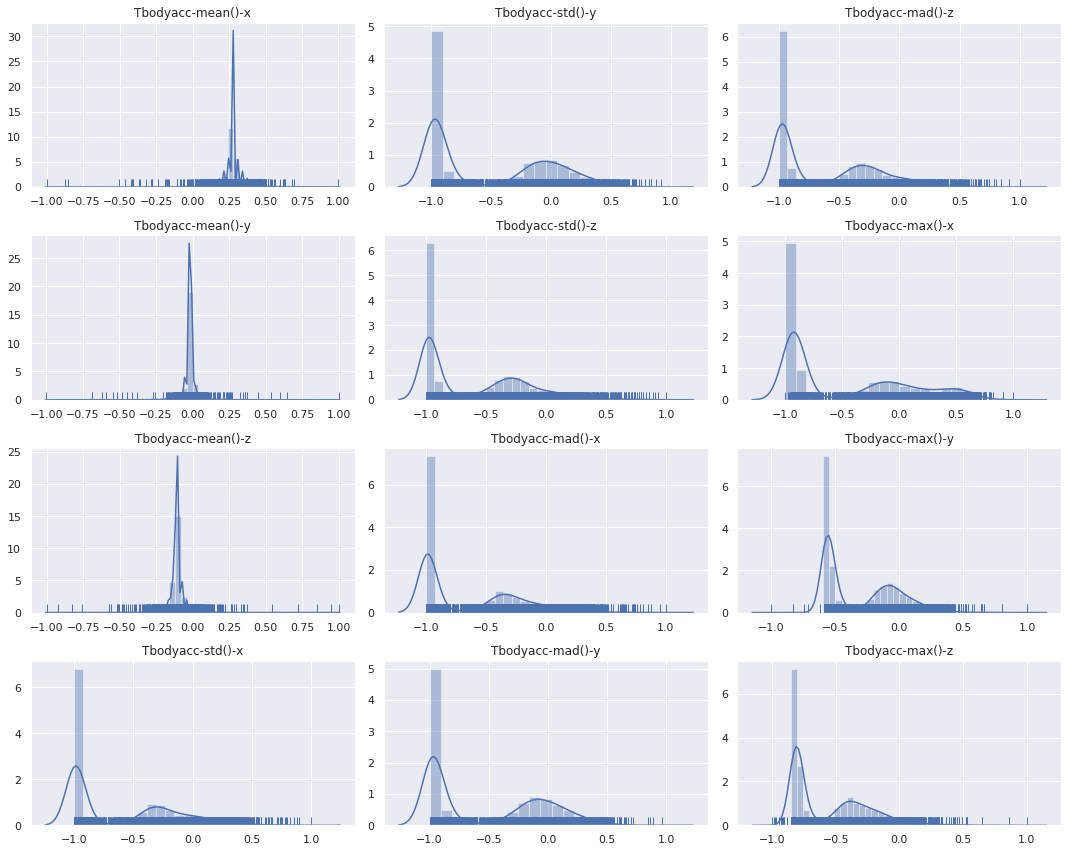

In [23]:
fig, ax = plt.subplots(figsize=(15,12), nrows=4, ncols=3)
counter = 0 
for column in train.columns[:12]:
  j = counter//4; i = counter%4;
  sns.distplot(train[column].values,ax=ax[i,j],rug=True)
  ax[i,j].set_title(column.capitalize())
  counter += 1
plt.subplots_adjust(hspace=0.5)
plt.tight_layout()
plt.show()

**Looking at the heatmap of correlations:**

One can see that some of the variables are very strongly correlated, but this can also be expected, as they are essentially characterizing different parameters of same six types of activity. 

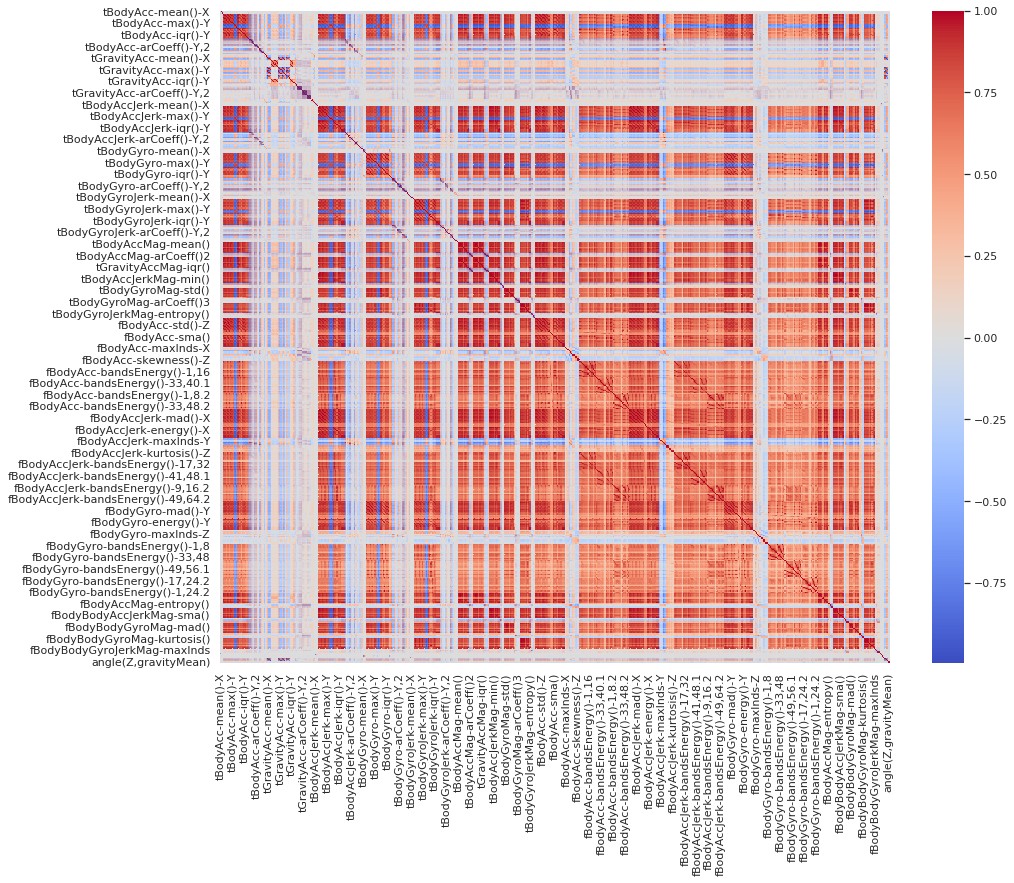

In [27]:
correlations = train.corr()
plt.figure(figsize=(15, 12))
sns.heatmap(correlations, cmap='coolwarm')
plt.show()

**Convenience of manual transformation:**

Given that there are 500+ variables in the dataset, manual removal of outliers is not an option, as it would be very costly in terms of time. 

**2. Prepare your dataset to train SVMs, considering the presence of categorical variables and the convenience of a scaling. Evaluate the need of a robust scaling instead of standard normalization.**


**Setting up the corresponding train and test sets:**

In [0]:
train_x = train.drop(['Activity'], axis = 1)
train_y = train['Activity']
test_x = test.drop(['Activity'], axis = 1)
test_y = test['Activity']
columns = train_x.columns

**Setting up the standard normalization:**

In [0]:
from sklearn.preprocessing import StandardScaler
scalerS = StandardScaler(with_mean = True, with_std = True)
scalerS.fit(train_x)
train_x_sscaled = scalerS.transform(train_x)
test_x_sscaled = scalerS.transform(test_x)
train_x_sscaled = pd.DataFrame(train_x_sscaled, columns = columns)
test_x_sscaled = pd.DataFrame(test_x_sscaled, columns = columns)

**Setting up the robust scaler:**

In [0]:
from sklearn.preprocessing import RobustScaler
scalerR = RobustScaler()
scalerR.fit(train_x)
train_x_rscaled = scalerR.transform(train_x)
test_x_rscaled = scalerR.transform(test_x)
train_x_rscaled = pd.DataFrame(train_x_rscaled, columns = columns)
test_x_rscaled = pd.DataFrame(test_x_rscaled, columns = columns)

**Visually checking the effects of the two scalers:**

From a subset of the first variables it can be seen that the results of the two scalers are largely similar in terms of shape, and the difference is reflected largely in the horizontal scale of the histograms. Overall, robust scaler is largely similar to a normal scaler, but uses the interquartile range of the distribution, and is therefore robust to outliers.In the case of the standard scaler, the computed means and standard deviations are sensative to the presence of outliers, and therefore can be not useful for the situations of skewed or extremely skewed data. Given that variables of the initial dataset were not normally distributed, it is probably more appropriate to use the robust scaler. 

[]

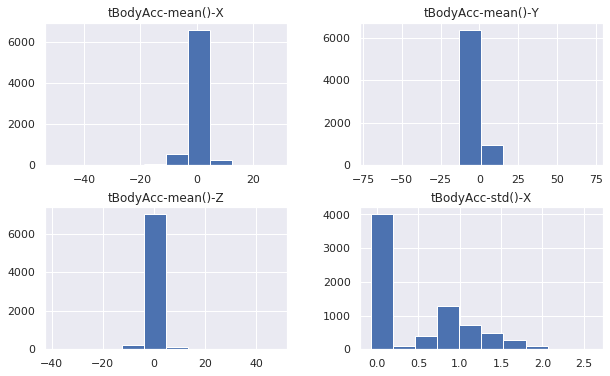

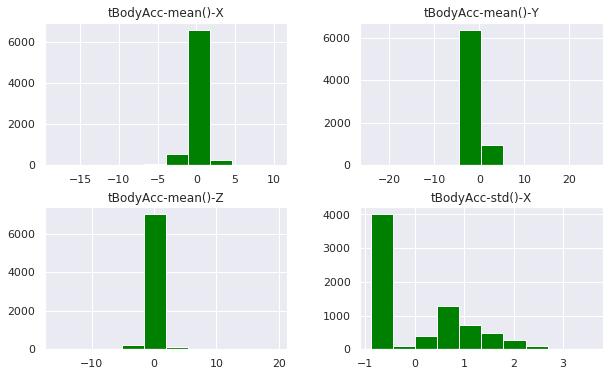

In [51]:
hist = train_x_rscaled.iloc[:,:4].hist(figsize=(10,6))
hist = train_x_sscaled.iloc[:,:4].hist(figsize=(10,6), color = "green")
plt.plot()

**3. Train a linear SVM, evaluating the impact of regularization on the test performance. Use cross-validation to choose values for the SVM (hyper) parameters. Can these values be chosen according to their performance on the train set? Can these values be chosen according to their performance on the test set?**



Effect of regularization: higher values of c produce lower values of the training error, but yet the test error can go higher because of the impact of overfitting (at least in the cases when the problem is linearly separable). 

**Training a linear SVM on the data obtained with the robust scaler, as it was defined in the previous step**:

In [55]:
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report

svm_ovr = OneVsRestClassifier(SVC(kernel='linear', C=1))

svm_ovr.fit(train_x_rscaled, train_y)

print("Accuracy score on the train data is",svm_ovr.score(train_x_rscaled, train_y))
print("Accuracy score on the test data is",svm_ovr.score(test_x_rscaled, test_y))

print("\nDetailed classification report - test set:\n")
print(classification_report(test_y, svm_ovr.predict(test_x_rscaled)))

Accuracy score on the train data is 0.9955114254624592
Accuracy score on the test data is 0.9575839837122497

Detailed classification report - test set:

                    precision    recall  f1-score   support

            LAYING       0.99      1.00      0.99       537
           SITTING       0.97      0.87      0.91       491
          STANDING       0.90      0.98      0.94       532
           WALKING       0.95      0.99      0.97       496
WALKING_DOWNSTAIRS       0.99      0.95      0.97       420
  WALKING_UPSTAIRS       0.97      0.95      0.96       471

          accuracy                           0.96      2947
         macro avg       0.96      0.96      0.96      2947
      weighted avg       0.96      0.96      0.96      2947



**Optimizing the parameters through cross-validation:**

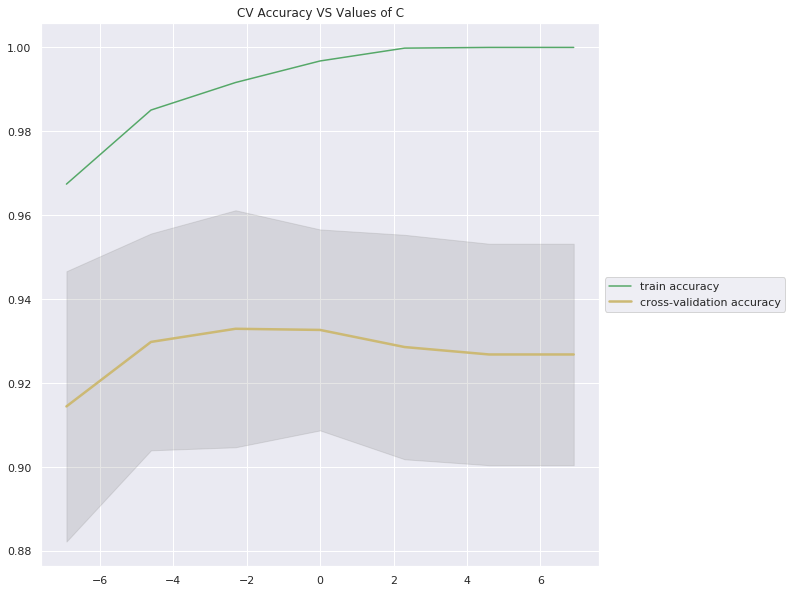


The identified optimal parameters are: 
{'estimator__C': 0.1, 'estimator__kernel': 'linear'}


In [61]:
from sklearn.model_selection import GridSearchCV
svm_ovr = OneVsRestClassifier(SVC(kernel='linear'))
parameters = {'estimator__kernel':['linear'], 'estimator__C': np.logspace(-3, 3, num=7, endpoint=True, base=10.0)}
gs_rs = GridSearchCV(svm_ovr, param_grid = parameters ,return_train_score=True)
gs_rs.fit(train_x_rscaled, train_y)

best_params_linear_rs = gs_rs.best_params_

C_values = np.logspace(-3, 3, num=7, endpoint=True, base=10.0)
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(np.log(C_values),gs_rs.cv_results_['mean_train_score'],color='g',lw=1.5,label='train accuracy')
ax.plot(np.log(C_values),gs_rs.cv_results_['mean_test_score'],color='y',lw=2.5,label='cross-validation accuracy')
plt.fill_between(np.log(C_values), gs_rs.cv_results_['mean_test_score']-gs_rs.cv_results_['std_test_score'], gs_rs.cv_results_['mean_test_score']+gs_rs.cv_results_['std_test_score'],color='gray', alpha=0.2)
plt.title("CV Accuracy VS Values of C")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

print("\nThe identified optimal parameters are: \n{}".format(best_params_linear_rs))

**Running the model on the test set with optimal parameters:**

Accuracy score on the train data is 0.9910228509249184
Accuracy score on the test data is 0.9545300305395318

Detailed classification report - test set:

                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.95      0.87      0.91       491
          STANDING       0.89      0.96      0.92       532
           WALKING       0.94      0.99      0.96       496
WALKING_DOWNSTAIRS       0.99      0.96      0.98       420
  WALKING_UPSTAIRS       0.97      0.94      0.96       471

          accuracy                           0.95      2947
         macro avg       0.96      0.95      0.95      2947
      weighted avg       0.96      0.95      0.95      2947


Confusion matrix - test set:



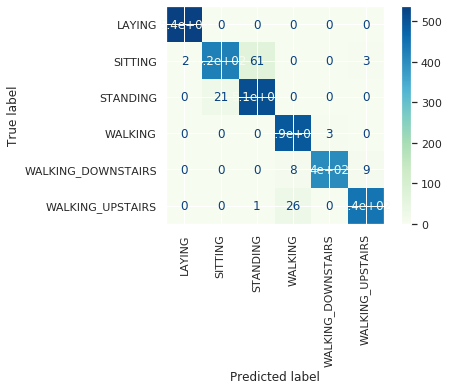

In [68]:
svm_best_rs = OneVsRestClassifier(SVC(kernel='linear', C=best_params_linear_rs['estimator__C']))
svm_best_rs.fit(train_x_rscaled, train_y)

print("Accuracy score on the train data is",svm_best_rs.score(train_x_rscaled, train_y))
print("Accuracy score on the test data is",svm_best_rs.score(test_x_rscaled,test_y))

print("\nDetailed classification report - test set:\n")
print(classification_report(test_y, svm_best_rs.predict(test_x_rscaled)))

cm = confusion_matrix(test_y, svm_best_rs.predict(test_x_rscaled))
print("\nConfusion matrix - test set:\n")
plot_confusion_matrix(svm_best_rs, test_x_rscaled, test_y, cmap=plt.cm.GnBu,xticks_rotation='vertical')
plt.show()

The values should not be chosen looking at the performance of the training set, or the higher values of c and non-linear kernels would always be preferred. They should't also be chosen looking at the test set, so that the error estimates are not biased. Either an evaluation set or cross-validation should be used. 

**4. Train non-linear SVMs, evaluating the impact of the kernel on the test performance. Include the RBF kernel in your analysis, explaining the theoretical effect of parameter gamma in the result. Contrast the theory with the empirical observations.**

The theoretical effect of the parameter gamma is in the neighborhood around the point, for very big values of gamma the neighborhood is very small, and if gamma is very small, the neighjborhood becomes larger, and more points are seen as "neighbors". In practice this means that the greater the value of gamma, the more flexible is the model, and therefore it can overfit the data more easily. 

**Training the non-linear SVMs on the data obtained from the robust scaler:**

In [69]:
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report

svm_ovr_nl = OneVsRestClassifier(SVC(kernel='rbf'))

svm_ovr_nl.fit(train_x_rscaled, train_y)

print("Accuracy score on the train data is",svm_ovr_nl.score(train_x_rscaled, train_y))
print("Accuracy score on the test data is",svm_ovr_nl.score(test_x_rscaled, test_y))

print("\nDetailed classification report - test set:\n")
print(classification_report(test_y, svm_ovr_nl.predict(test_x_rscaled)))

Accuracy score on the train data is 0.9760609357997824
Accuracy score on the test data is 0.9436715303698676

Detailed classification report - test set:

                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.92      0.89      0.90       491
          STANDING       0.90      0.93      0.92       532
           WALKING       0.94      0.97      0.95       496
WALKING_DOWNSTAIRS       0.95      0.92      0.93       420
  WALKING_UPSTAIRS       0.95      0.95      0.95       471

          accuracy                           0.94      2947
         macro avg       0.94      0.94      0.94      2947
      weighted avg       0.94      0.94      0.94      2947



**Optimizing the parameters through cross-validation:**

In [0]:
from sklearn.model_selection import GridSearchCV

svm = SVC()
parameters = [
    {'C': np.logspace(-1, 1, num=3, endpoint=True, base=10.0), 'gamma': [0.01, 0.02, 0.1, 0.2], 'kernel': ['rbf']},
    {'C': np.logspace(-1, 1, num=3, endpoint=True, base=10.0), 'gamma': [0.01, 0.02, 0.1, 0.2], 'kernel': ['poly']}]

gs_rs_nl = GridSearchCV(svm, param_grid = parameters ,return_train_score=True)
gs_rs_nl.fit(train_x_rscaled, train_y)

best_params_linear_rs_nl = gs_rs_nl.best_params_

means = gs_rs_nl.cv_results_['mean_test_score']
stds = gs_rs_nl.cv_results_['std_test_score']
params = gs_rs_nl.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
   
print("\nBEST RESULTS ...\n")
print("PARAMS: ",gs_rs_nl.best_params_)
print("SCORE: ",gs_rs_nl.best_score_)

**Running the new model on the test set with optimal parameters:**

In [0]:
best_nl_rs_C = gs_rs_nl.best_params_['C']
best_nl_rs_kernel = gs_rs_nl.best_params_['kernel']
best_nl_rs_gamma = gs_rs_nl.best_params_['gamma']

svm_best_rs_nl = OneVsRestClassifier(SVC( C=best_nl_rs_C, kernel=best_nl_rs_kernel, gamma = best_nl_rs_gamma))
svm_best_rs_nl.fit(train_x_rscaled, train_y)

print("Accuracy score on the train data is",svm_best_rs_nl.score(train_x_rscaled, train_y))
print("Accuracy score on the test data is",svm_best_rs_nl.score(test_x_rscaled,test_y))

print("\nDetailed classification report - test set:\n")
print(classification_report(test_y, svm_best_rs_nl.predict(test_x_rscaled)))

cm = confusion_matrix(test_y, svm_best_rs_nl.predict(test_x_rscaled))
print("\nConfusion matrix - test set:\n")
plot_confusion_matrix(svm_best_rs_nl, test_x_rscaled, test_y, cmap=plt.cm.GnBu,xticks_rotation='vertical')
plt.show()

It can be seen that in this specific example the accuracy score was not improved under a non-linear kernel. 

**5. Determine the variables of the dataset to which the linear SVM obtained in 3 gives more weight in the decision function. Are these values proportional to the importance of the attribute?**


Below is one example of the most essential features for class comparison, in this case for distinguishing between the features of "laying" and "standing". Overall, the variables with the greatest weights are the most important variables in the model. However, if some different model was run (such as for instance the Random Forest classifier), the important variables determined by the model could be different. The values determined below are indeed proportional to the importance of the attribute in the SVM model. 

In [0]:
class_comparison = {'LAYING-SITTING': 1, 'LAYING-STANDING' : 2, 'LAYING-WALKING' : 3, 'LAYING-WALKING_DOWNSTARS' : 4,
                   'LAYING-WALKING-UPSTAIRS' : 5, 'SITTING-STANDING' : 6, 'SITTING-WALKING' : 7, 'SITTING-WALKING_DOWNSTARS' : 8,
                   'SITTING-WALKING_UPSTAIRS' : 9, 'STANDING-WALKING' : 10, 'STANDING-WALKING_DOWNSTAIRS' : 11, 'STANDING-WALKING_UPSTAIRS' : 12,
                   'WALKING-WALKING_DOWNSTAIRS' : 13, 'WALKING-WALKING_UPSTAIRS' : 14, 'WALKING_DOWNSTAIRS-WALKING_UPSTAIRS' : 15}


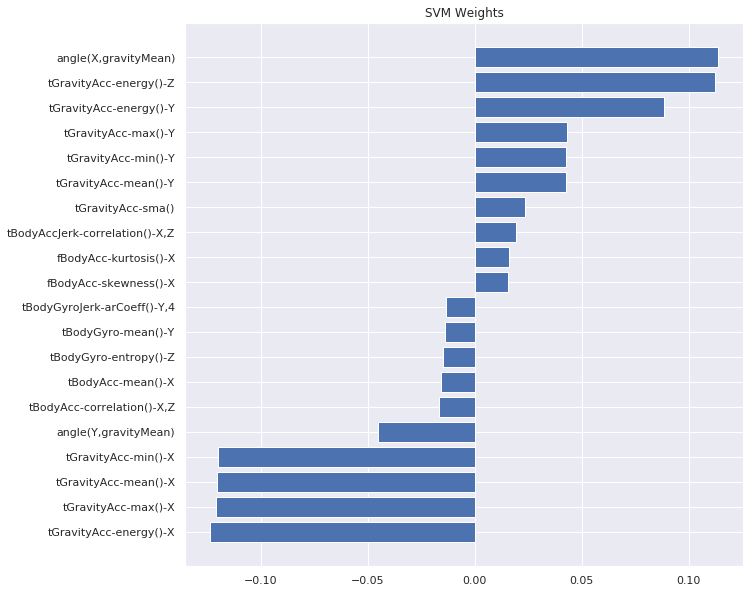

In [79]:
svm = SVC(kernel='linear', C=1)
svm.fit(train_x_sscaled,train_y)

w = svm.coef_
w = pd.DataFrame(w)
w.columns = train_x_sscaled.columns
w = pd.DataFrame.transpose(w)

coefficient_N = class_comparison['LAYING-SITTING'] 
for i in ['LAYING-SITTING']:
    w_sorted = pd.DataFrame.sort_values(w, coefficient_N, ascending = False)
    
    minmax = w_sorted.nlargest(10, [coefficient_N])[coefficient_N]
    minmax = minmax.append(w_sorted.nsmallest(10,[coefficient_N])[coefficient_N])
    minmax = minmax.sort_values()
            
    fig, ax = plt.subplots(figsize=(10,10))
    var_idx = range(0,len(minmax))
    ax.barh(var_idx, minmax, align='center')
    ax.set_yticks(var_idx)
    ax.set_yticklabels(minmax.index)
    plt.title("SVM Weights")
    plt.show()

**6. Compare the number of support vectors in the linear and non-linear models from activities 3 and 4. Mention a practical consequence of a large support set.**


Number of support vectors %d [101 167 167 115 108 142]


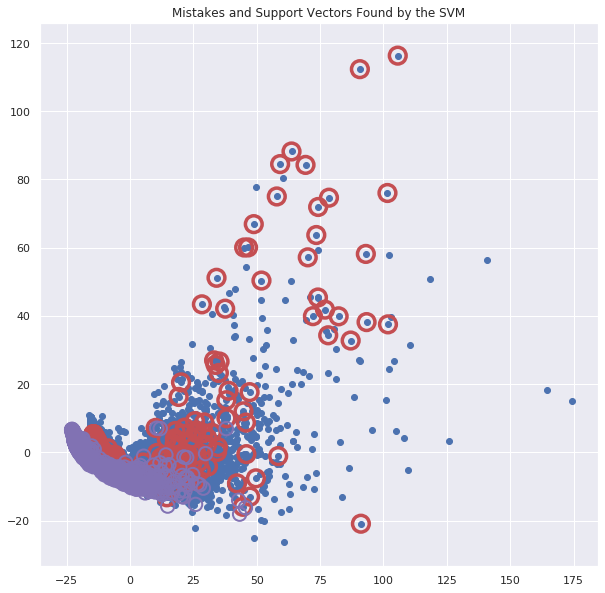

In [82]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(train_x_rscaled)
train_x_projected = pca.transform(train_x_rscaled)
train_y_pred = svm.predict(train_x_rscaled)
decision_train = svm.decision_function(train_x_rscaled)
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(train_x_projected[:,0],train_x_projected[:,1],cmap = train_y)


train_x_rscaled2 = train_x_rscaled.copy()
train_x_rscaled2.insert(0, 'prediction', train_y_pred)
mistakes_x = train_x_rscaled2[train_y != train_y_pred]
mistakes_x_projected = pca.transform(mistakes_x.drop(['prediction'], axis = 1))
ax.scatter(mistakes_x_projected[:,0],mistakes_x_projected[:,1], s=280, facecolors='none',edgecolors='r',linewidth=3.5)

sv = svm.support_vectors_ #support vectors
nsv = svm.n_support_ #number of support vectors
sv_idx = svm.support_ #indices of support vectors
sv_projected = pca.transform(sv)

print("Number of support vectors %d", nsv)

ax.scatter(sv_projected[:,0],sv_projected[:,1], s=180, facecolors='none',edgecolors='m',linewidth=2)
plt.title("Mistakes and Support Vectors Found by the SVM")
plt.show()

**Similar for the non-linear model:**

Number of support vectors %d [129 623 583 498 627 544]


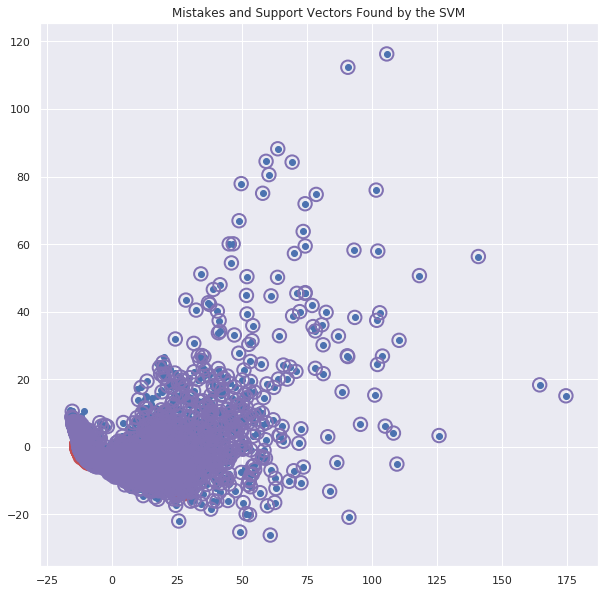

In [83]:

svm_nl = SVC(kernel='rbf', C=1, gamma = 'scale')
svm_nl.fit(train_x_rscaled,train_y)

pca = PCA(n_components=2)
pca.fit(train_x_rscaled)
train_x_projected_nl = pca.transform(train_x_rscaled)
train_y_pred_nl = svm_nl.predict(train_x_rscaled)
decision_train_nl = svm_nl.decision_function(train_x_rscaled)
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(train_x_projected_nl[:,0],train_x_projected_nl[:,1],cmap=train_y)


train_x_rscaled2 = train_x_rscaled.copy()
train_x_rscaled2.insert(0, 'prediction', train_y_pred_nl)
mistakes_x_nl = train_x_rscaled2[train_y != train_y_pred_nl]
mistakes_x_projected_nl = pca.transform(mistakes_x_nl.drop(['prediction'], axis = 1))
ax.scatter(mistakes_x_projected_nl[:,0],mistakes_x_projected_nl[:,1], s=280, facecolors='none',edgecolors='r',linewidth=3.5)

sv_nl = svm_nl.support_vectors_ #support vectors
nsv_nl = svm_nl.n_support_ #number of support vectors
sv_idx_nl = svm_nl.support_ #indices of support vectors
sv_projected_nl = pca.transform(sv_nl)

print("Number of support vectors %d", nsv_nl)

ax.scatter(sv_projected_nl[:,0],sv_projected_nl[:,1], s=180, facecolors='none',edgecolors='m',linewidth=2)
plt.title("Mistakes and Support Vectors Found by the SVM")
plt.show()

The number of support vectors for the linear model is higher than for the non-linear, which shows both its flexibility and proneness to overfitting. 

**7. Choose, explain and compare two different strategies to handle multiple classes (perhaps you did not notice, but in the activities 3 and 4 your classifier selected an heuristic to extend the SVM to multiple categories).**

The two strategies are One-vs-One and One-vs-Rest. Their comparison is shown below. Overall, in one versus rest a separate classifier is created for each class, and the probability of belonging to each class is calculated.Then, the observation gets assigned to the class with the highest associated probability. As for the one versus one, all classes are compared with each other, and the highest rated class basing on the data from all peirs gets assigned.

In [85]:
svm_ovr = OneVsRestClassifier(SVC(kernel='linear', C=1))

svm_ovr.fit(train_x_rscaled, train_y)

print("OVR GLOBAL ACCURACY TRAIN SET (LIB)",svm_ovr.score(train_x_rscaled, train_y))
print("OVR GLOBAL ACCURACY TEST SET (LIB)",svm_ovr.score(test_x_rscaled, test_y))

print("OVR \nDETAILED REPORT TEST SET:\n")
print(classification_report(test_y, svm_ovr.predict(test_x_rscaled)))
svm_ovo = SVC(kernel='linear', C=1)

svm_ovo.fit(train_x_rscaled, train_y)

print("OVO GLOBAL ACCURACY TRAIN SET (LIB)",svm_ovo.score(train_x_rscaled, train_y))
print("OVO GLOBAL ACCURACY TEST SET (LIB)",svm_ovo.score(test_x_rscaled, test_y))

print("OVO \nDETAILED REPORT TEST SET:\n")
print(classification_report(test_y, svm_ovo.predict(test_x_rscaled)))

OVR GLOBAL ACCURACY TRAIN SET (LIB) 0.9955114254624592
OVR GLOBAL ACCURACY TEST SET (LIB) 0.9575839837122497
OVR 
DETAILED REPORT TEST SET:

                    precision    recall  f1-score   support

            LAYING       0.99      1.00      0.99       537
           SITTING       0.97      0.87      0.91       491
          STANDING       0.90      0.98      0.94       532
           WALKING       0.95      0.99      0.97       496
WALKING_DOWNSTAIRS       0.99      0.95      0.97       420
  WALKING_UPSTAIRS       0.97      0.95      0.96       471

          accuracy                           0.96      2947
         macro avg       0.96      0.96      0.96      2947
      weighted avg       0.96      0.96      0.96      2947

OVO GLOBAL ACCURACY TRAIN SET (LIB) 0.9960554951033732
OVO GLOBAL ACCURACY TEST SET (LIB) 0.9541907024092298
OVO 
DETAILED REPORT TEST SET:

                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00     

**8. Evaluate the performance of linear and non-linear SVMs on each class, measuring accuracy, precision and recall. Explain the difference between the different metrics.**


As compared to the linear model, non-linear model has higher errors. Some of the biggest differences is the decrease of recall for the walking downstairs activity. Overall, the confusion matrix helps to evaluate the performance of the classification model, setting the true versus predicted values of classes. Recall is the rate of positives that are correctly classified by the model (also called sensitivity). Recall = (true positives / (true positives + false negatives)). Precision is the rate of true positives among the number of positive classifications. Precision = (true positives / (true positives + false positives)). Lastly, accuracy is the number of correctly labeled observations / total observations. 

Linear SVM
GLOBAL ACCURACY TRAIN SET (LIB) 0.9910228509249184
GLOBAL ACCURACY TEST SET (LIB) 0.9545300305395318

DETAILED REPORT TEST SET:

                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.95      0.87      0.91       491
          STANDING       0.89      0.96      0.92       532
           WALKING       0.94      0.99      0.96       496
WALKING_DOWNSTAIRS       0.99      0.96      0.98       420
  WALKING_UPSTAIRS       0.97      0.94      0.96       471

          accuracy                           0.95      2947
         macro avg       0.96      0.95      0.95      2947
      weighted avg       0.96      0.95      0.95      2947


CONFUSION MATRIX TEST SET:



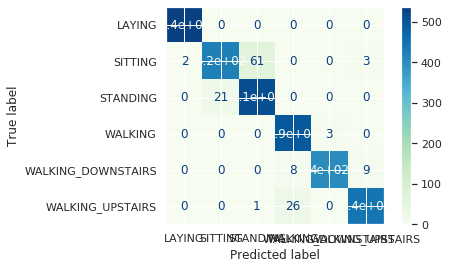

Non-linear SVM


NameError: ignored

In [88]:
print('Linear SVM')

print("GLOBAL ACCURACY TRAIN SET (LIB)",svm_best_rs.score(train_x_rscaled, train_y))
print("GLOBAL ACCURACY TEST SET (LIB)",svm_best_rs.score(test_x_rscaled,test_y))

print("\nDETAILED REPORT TEST SET:\n")
print(classification_report(test_y, svm_best_rs.predict(test_x_rscaled)))

cm = confusion_matrix(test_y, svm_best_rs.predict(test_x_rscaled))
print("\nCONFUSION MATRIX TEST SET:\n")
plot_confusion_matrix(svm_best_rs, test_x_rscaled, test_y, cmap=plt.cm.GnBu)
plt.show()

print('Non-linear SVM')
print("GLOBAL ACCURACY TRAIN SET (LIB)",svm_best_rs_nl.score(train_x_rscaled, train_y))
print("GLOBAL ACCURACY TEST SET (LIB)",svm_best_rs_nl.score(test_x_rscaled,test_y))

print("\nDETAILED REPORT TEST SET:\n")
print(classification_report(test_y, svm_best_rs_nl.predict(test_x_rscaled)))

cm = confusion_matrix(test_y, svm_best_rs_nl.predict(test_x_rscaled))
print("\nCONFUSION MATRIX TEST SET:\n")
plot_confusion_matrix(svm_best_rs_nl, test_x_rscaled, test_y, cmap=plt.cm.GnBu)


**9. Evaluate the need of class balancing to increase the performance on the categories with the worst results.**

Some of the categories with the worst results are sitting and standing, and it can be seen that they are not under-represented in the dataset.Therefore, in this perspective class balancing does not seem to be necessary. Furthermore, given that the classification accuracy was largely over 95% accross models, increasing computational complexity could probably provide an only marginal overall gain. Furthermore, assuming that the smartphone activity recognition is frequently used for tracking of fitness-related activities, distinguishing between sitting and standing can prove to be not so essential. 